# Max Regression

A demo of the toy max-regression problem from the paper. These models learn to approximate the largest number in the given set, regardless of the order presented.

In [1]:
import sys

In [2]:
sys.path.append("../../../deep-learning-dna")
sys.path.append("../")
sys.path.append("../../../deep-learning-dna/common")

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import tf_utils as tfu

from Attention import Set_Transformer as stf

In [16]:
strategy = tfu.devices.select_gpu(0, use_dynamic_memory=True)

---
## Data Generation

The following function generates a batch sets, each consisting of *length* numbers.

In [17]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    return x, y # (batch_size, length)

In [18]:
x, y = gen_data(5, 10)

In [19]:
print(x.shape, y.shape)

(5, 10) (5,)


In [20]:
x

array([[10, 81, 70, 74, 89, 91, 41,  7, 40, 51],
       [34, 61, 46, 94, 13, 40, 98, 95, 97,  2],
       [47,  3, 73, 64, 78, 38, 38, 52, 96,  3],
       [97, 89, 54, 50, 13, 39, 57, 99, 20, 17],
       [ 8, 71, 64, 55, 28, 41, 79, 49, 13, 97]])

In [21]:
y

array([91, 98, 96, 99, 97])

---
## Model

This model learns to approximate the largest number in the given set of numbers, regardless of the order presented.

In [22]:
def create_model(
    embed_dim=64,
    num_heads=4,
    stack=2,
    use_layernorm=False,
    pre_layernorm=False,
    use_keras_mha=False # Use Keras' MHA implementation over the traditional Vaswani implementation
):
    y = x = keras.layers.Input((None,))
    print(x.shape)
    y = keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(y)
    y = keras.layers.Dense(embed_dim)(y)
    for _ in range(stack):
        y = stf.SetAttentionBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                use_layernorm=use_layernorm,
                pre_layernorm=pre_layernorm,
                use_keras_mha=use_keras_mha)(y)

    y = stf.PoolingByMultiHeadAttention(
            num_seeds=1,
            embed_dim=embed_dim,
            num_heads=1,
            use_layernorm=use_layernorm,
            pre_layernorm=pre_layernorm,
            use_keras_mha=use_keras_mha,
            is_final_block=True)(y)
    y = keras.layers.Dense(1)(y)
    y = keras.layers.Lambda(lambda x: tf.squeeze(x))(y)

    return keras.Model(x, y)

---
## Training (No Layernorm)

In [23]:
model = create_model(use_layernorm=False)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

(None, None)


ValueError: Exception encountered when calling layer "set_attention_block" (type SetAttentionBlock).

in user code:

    File "/home/jovyan/work/TransformerXL/STR_XL/Notebooks/../Attention/Set_Transformer/__init__.py", line 270, in call  *
        return super().call([x, mems], training=training)
    File "/home/jovyan/work/TransformerXL/STR_XL/Notebooks/../Attention/Set_Transformer/__init__.py", line 239, in call  *
        return self.call_post_layernorm(x, y, training)
    File "/home/jovyan/work/TransformerXL/STR_XL/Notebooks/../Attention/Set_Transformer/__init__.py", line 221, in call_post_layernorm  *
        attn = x + self.att(x, y, y, training=training)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "vaswani_multi_head_attention" (type VaswaniMultiHeadAttention).
    
    in user code:
    
        File "/home/jovyan/work/TransformerXL/STR_XL/Notebooks/../Attention/Set_Transformer/__init__.py", line 138, in call  *
            q_split = tf.concat(tf.split(q, self.num_heads, 2), 0)
    
        ValueError: Dimension size, given by scalar input 2 must be in range [-2, 2) for '{{node set_attention_block/vaswani_multi_head_attention/split}} = Split[T=DT_FLOAT, num_split=4](set_attention_block/vaswani_multi_head_attention/split/split_dim, set_attention_block/vaswani_multi_head_attention/dense_3/BiasAdd)' with input shapes: [], [?,64] and with computed input tensors: input[0] = <2>.
    
    
    Call arguments received:
      • q=tf.Tensor(shape=(None, 64), dtype=float32)
      • v=tf.Tensor(shape=(None, 128), dtype=float32)
      • k=tf.Tensor(shape=(None, 128), dtype=float32)
      • training=None


Call arguments received:
  • inputs=tf.Tensor(shape=(None, None, 64), dtype=float32)
  • training=None

In [ ]:
x[:4]

In [24]:
#5, 10

In [ ]:
model(x[:4])

In [ ]:
model.predict(x[:2])

In [ ]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [ ]:
history_nln = model.fit(x, y, epochs=500, verbose=0)

In [ ]:
x[:3]

In [ ]:
model.predict(x[:3])

---
## Training (Post-Layernorm)

In [12]:
model = create_model(use_layernorm=True, pre_layernorm=False)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

(None, None)


NameError: name 'stf' is not defined

In [22]:
x[:2]

array([[32, 18, 82, 83, 65],
       [51, 32, 22, 82, 28]])

In [23]:
model.predict(x[:2])

array([-2.483456 , -2.5711875], dtype=float32)

In [24]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [28]:
history_post_ln = model.fit(x, y, epochs=500, verbose=0)

In [26]:
x[:3]

array([[ 1, 51, 91, 97, 91],
       [41, 42, 33, 82, 53],
       [15, 80, 33, 95, 33]])

In [27]:
model.predict(x[:3])

array([96.06869, 83.52949, 95.00522], dtype=float32)

---
## Training (Pre-Layernorm)

In [28]:
model = create_model(use_layernorm=True, pre_layernorm=True)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

In [29]:
x[:2]

array([[ 1, 51, 91, 97, 91],
       [41, 42, 33, 82, 53]])

In [30]:
model.predict(x[:2])

array([-1.484148 , -1.4941418], dtype=float32)

In [31]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [32]:
history_pre_ln = model.fit(x, y, epochs=500, verbose=0)

In [33]:
x[:3]

array([[14, 21,  4, 92, 39],
       [52,  6, 83, 53, 93],
       [46, 83, 11, 38, 78]])

In [34]:
model.predict(x[:3])

array([92.11145 , 93.088806, 83.09186 ], dtype=float32)

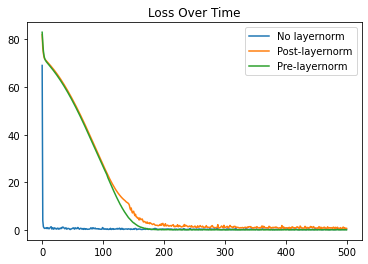

In [37]:
plt.plot(history_nln.history["loss"])
plt.plot(history_post_ln.history["loss"])
plt.plot(history_pre_ln.history["loss"])
plt.legend(["No layernorm", "Post-layernorm", "Pre-layernorm"])
plt.title("Loss Over Time")
plt.show()